In [10]:
"""Verify if generalized f-mean of two gaussians is gaussian."""

import FrEIA.framework as Ff
import FrEIA.modules as Fm

import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons
from pathlib import Path

In [11]:
BATCHSIZE = 10000
N_DIM = 2

In [12]:
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512, dims_out))


# a simple chain of operations is collected by ReversibleSequential
flow = Ff.SequenceINN(N_DIM)
for k in range(8):
    flow.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

Train flow to transform gaussian distr into moon distr

In [13]:
state_dict_path = Path('flow')
if state_dict_path.exists():
    flow.load_state_dict(torch.load(state_dict_path))
    moon_data, _ = make_moons(n_samples=BATCHSIZE, noise=0.05)
else:
    optimizer = torch.optim.Adam(flow.parameters(), lr=0.001)

    for i in range(1000):
        optimizer.zero_grad()
        # sample data from the moons distribution
        moon_data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
        x = torch.Tensor(moon_data)
        # pass to INN and get transformed variable z and log Jacobian determinant
        z, log_jac_det = flow(x)
        # calculate the negative log-likelihood of the model with a standard normal prior
        loss = 0.5 * torch.sum(z ** 2, 1) - log_jac_det
        loss = loss.mean() / N_DIM
        # backpropagate and update the weights
        loss.backward()
        optimizer.step()
    torch.save(flow.state_dict(), 'flow')

In [14]:
data1 = torch.randn(BATCHSIZE, N_DIM)
data2 = torch.randn(BATCHSIZE, N_DIM)
z1, _ = flow(data1, rev=True)
z2, _ = flow(data2, rev=True)
z_prime = (z1 + z2) / 2
z, _ = flow(z_prime)

In [15]:
data = data1.numpy()
z_prime = z_prime.detach().numpy()
z = z.detach().numpy()
z1 = z1.detach().numpy()

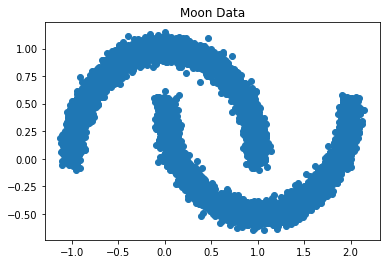

In [16]:
plt.title('Moon Data')
plt.scatter(moon_data[:, 0], moon_data[:, 1])
plt.show()

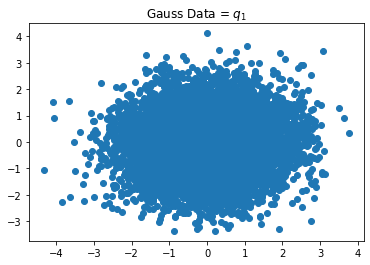

In [30]:
plt.title('Gauss Data = $q_1$')
plt.scatter(data[:, 0], data[:, 1])
plt.show()

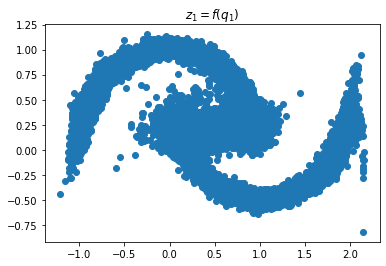

In [22]:
plt.title('$z_1 = f(q_1)$')
plt.scatter(z1[:, 0], z1[:, 1])
plt.show()

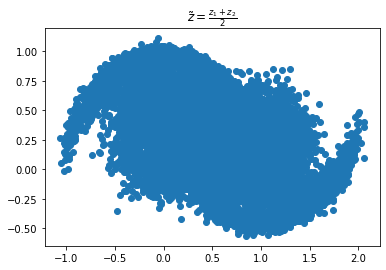

In [28]:
plt.title(r'$\tilde{z} = \frac{z_1 + z_2}{2}$')
plt.scatter(z_prime[:, 0], z_prime[:, 1])
plt.show()

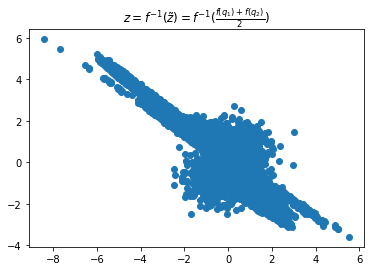

In [29]:
plt.title(r'$z = f^{-1}(\tilde{z}) = f^{-1}(\frac{f(q_1) + f(q_2)}{2})$')
plt.scatter(z[:, 0], z[:, 1])
plt.show()